# Assignment 3b Cognitive Modelling

Dit is onderdeel van de derde opdracht voor Cognitive Modelling. Hieronder volgen vragen over 1-layer Q Networks. In totaal bestaat de derde opdracht uit drie onderdelen:
* Assignment 3a
* __Assignment 3b__ (SimpleNetwork, in Google Colab) 
* Assignment 3c (Doom, in Google Colab)

Bij elke vraag staat de hoeveelheid punten die je er voor kan krijgen. In totaal kan je voor deze opdracht __19 punten__ halen. Geef antwoorden in blokken met code of met tekst. Gebruik voor antwoorden met tekst de ">" voor blockquotes en geef bij elke vraag ook __kort uitleg__ als hier om wordt gevraagd. __Let op__: soms staan er meerdere vragen bij een onderdeel, lees de tekst dus nauwkeurig. 

Sla het uiteindelijke notebook op met jullie studentnummers en achternamen in de filenaam: `studentnummer1_achternaam1_studentnummer2_achternaam2_opdrachtnummer`.

<br>

## 1. Q Networks

We hebben nu gewerkt met een kleine wereld met maar maximaal 64 states. De echte wereld, en veel leuke spelletjes, hebben natuurlijk een veel grotere state space, en dan wordt het al snel erg lastig om nog een Q table te gaan bijhouden. Dit is waar Q netwerken heel handig zijn, en dan met name Deep Q Networks (DQN). Een deep neural network kan helpen de state space een stuk beter generaliseerbaar te maken, en vergelijkbare Q-values toekennen aan states die veel op elkaar lijken, wat een hele waardevolle eigenschap blijkt (zie bijv. de oorspronkelijke DQN paper over Atari games leren spelen [hier](https://arxiv.org/pdf/1312.5602v1.pdf)).


__TensorFlow__

In deze opdracht gaan we nu geen deep Q netwerk in elkaar zetten maar wel een simpel 1-layer Q netwerk, om te leren hoe deze werken en hoe het Q-learning algoritme kan worden geïmplementeerd in een netwerk. We maken hier gebruik van pytorch, een library waarmee je (deep) neural networks kan definiëren en trainen.

__FrozenLake__

We gebruiken voor deze eerste uitleg weer de kleine frozenlake omgeving: `gym.make('FrozenLake-v1',map_name="4x4",is_slippery=False, render_mode="rgb_array")`

In [1]:
!pip install gymnasium


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\thijn\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import numpy as np
import random
import os

%matplotlib inline
import matplotlib.pyplot as plt

# init Lake
env_4x4 = gym.make(
    'FrozenLake-v1',
    map_name="4x4",
    is_slippery=False,
    render_mode="rgb_array"
    )

<br>

We gaan een simpel Q netwerk opzetten waarbij er voor elke state (in totaal 16) een node is in de input laag, en voor elke actie (4) een node in the output laag. 

Het doel is om de gewichten (weights) van het netwerk zo te trainen dat een gegeven state als input correspondeert met de 4 output Q-values van de 4 verschillende acties voor die state.

![](Images\QNET.png)
##### _in deze illustratie zie je het netwerk twee keer in verschillende states_


Vervolgens kunnen we een *argmax* gebruiken om de actie met met hoogste Q-value te selecteren. Er zijn 16 input nodes, waarbij elke state nu gerepresenteerd kan worden met een 🔥[one-hot encoding](https://en.wikipedia.org/wiki/One-hot)🔥, dus door alleen de input node van die state op 1 te zetten en alle andere input nodes op 0.

Het 'Qnetwork' is gedefineerd als de matrix vermenigvuldiging van inputs en weights, dus simpelweg de som van de inputs vermenigvuldig met de weights voor elke output (deze manier om een neural network te definiëren zou je bekend moeten voorkomen uit **Leren**). Er is hier dus *geen* activatiefunctie (zoals bijv. Sigmoid of ReLU), i.e. dit is een netwerk met alleen een lineaire layer.

__Prediction error & learning__

Heel erg vergelijkbaar met Q-learning zoals je het hiervoor gezien hebt is er een prediction error:

$$\delta = r_{t+1} + \gamma\ max_a\ Q(s_{t+1} , a) − Q(s_t , a_t)$$

We gaan er dus weer even van uit dat in de volgene state $s_{t+1}$ de actie $a$ met de hoogste Q-value wordt gekozen (we hebben in de colleges gezien dat andere opties ook mogelijk zijn). 

Alleen nu is het niet zo dat de Q-values direct worden ge-update met de de prediction error $\delta$ maar dat de gewichten van de verbindingen in het netwerk worden aangepast. Deze worden zo aangepast om de toekomstige prediction error te minimaliseren. 

Het gaat voor deze opdracht te ver om in te gaan op hoe de weights in het netwerk worden aangepast, maar als het goed is leer je dit bij een ander vak. 


In [3]:
# Define the neural network for Q-learning
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc = nn.Linear(state_size, action_size,bias=False)
        torch.nn.init.uniform_(self.fc.weight, 0, )  # Uniform initialization

    def forward(self, x):
        return self.fc(x)

def q_network(env, num_episodes=250, num_rounds=999,PATH=None,filename=None):
    state_size = env.observation_space.n
    print(env.observation_space)
    action_size = env.action_space.n
    print(env.action_space)
    model = QNetwork(state_size, action_size)
    optimizer = optim.SGD(model.parameters(), lr=0.5)
    criterion = nn.MSELoss()

    if PATH != None and (not os.path.exists(PATH)):
        os.makedirs(f"{PATH}")

    # Set learning parameters
    y = 0.97
    e = 0.3

    # Create lists to contain total rewards and steps per episode
    jList = [] # list of steps taken in episode
    rList = [] # list of rewards
    aList = [] # list of actions
    Qvalues_init = [] # list of Qvalues per state begin
    Qvalues_final = [] # list of Qvalues per state end

    W_init = model.fc.weight.data.clone()  # Save initial weights

    # Get Q_values
    for state in range(state_size):
        state_tensor = torch.FloatTensor(np.identity(state_size)[state]).unsqueeze(0)
        Q_values = model(state_tensor)
        Qvalues_init.append(Q_values.detach().numpy())


    for i in range(num_episodes):
        state, _ = env.reset()
        rAll = 0
        done = False
        j = 0
        while not done and j < num_rounds:
            j += 1

            # make one hot encoding state+get Q_values
            state_tensor = torch.FloatTensor(np.identity(state_size)[state]).unsqueeze(0)
            Q_values = model(state_tensor)

            # choose an action based on the Q_values for that state
            _, predicted_action = torch.max(Q_values, 1)

            #e greedy:
            if np.random.rand(1) < e:
                action = env.action_space.sample()
            else:
                action = predicted_action.item()
            aList.append(action)

            #Get new state and reward from environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # get the next state and reward for action
            if done and reward == 0:
                reward = -1

            # Obtain the Q values of the next state by feeding the new state through our network, 
            # and again assuming you will choose the action with the highest Q value
            next_state_tensor = torch.FloatTensor(np.identity(state_size)[next_state]).unsqueeze(0)
            next_Q_values = model(next_state_tensor)

            # Obtain maxQ' of next state and use this to update the Q value of our chosen action.
            targetQ = Q_values.detach().clone()
            targetQ[0][action] = reward + y * torch.max(next_Q_values)#in list of targetQ values for s, update the Q value of chosen action

            # targetQ, where you only updated the Q-value of the chosen action, is the set of Q-values that you want to network to 
            # output next time the agent is in state s. In a network we cannot directly update Qvalues because they are the output of the weights 
            # so we will tune the weights such that they will result in something closer to targetQ. 
            # The prediction error is thus the difference between targetQ and Qout
            
            # Train our network using targetQ list, we try to adjust weights in order to 
            # minimize prediction error or squared error. 
            loss = criterion(Q_values, targetQ)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            rAll += reward
            state = next_state

        e*=0.995
        jList.append(j)
        rList.append(rAll)        
        
    Weights = model.fc.weight.data.clone()  # Save weights after training

    # Get Q_values for final state
    for state in range(state_size):
        state_tensor = torch.FloatTensor(np.identity(state_size)[state]).unsqueeze(0)
        Q_values = model(state_tensor)
        Qvalues_final.append(Q_values.detach().numpy())

    # save the model
    if PATH != None:
        if filename==None:
            filename="model"
        torch.save(model.state_dict(), PATH+filename+".pt")
        print("model saved as ", PATH+filename+".pt")

    return (rList, jList, action, W_init, Weights, Qvalues_init, Qvalues_final)

<br>

### __Q1.a__ (4 punten)
Bestudeer bovenstaande code. Er zijn een aantal verschillen en overeenkomsten met standaard Q-learning met Q tables. Beantwoord de volgende vragen:

1. Maakt dit algoritme een explore-exploit trade-off? Zo ja hoe?
2. Is er een equivalent van de learning rate? 
3. Wat is de prediction error?

> *Antwoord*
# SNORBEN
1. Maakt dit algoritme een explore-exploit trade-off? Zo ja hoe?
- Ja, het model past een e greedy toe wat beteknt dat het een ramdom step sampled

2. Is er een equivalent van de learning rate? 
- Het model heeft een learning rate parameter lr, deze past aan hoe sterk de weigths van het model worden aangepast
3. Wat is de prediction error?
-  De prediction error is het verschil tussen targetQ en Qout

<br>

### __Q1.b__ (4 punten)
We gaan het netwerk nu 1 keuze laten maken en goed kijken wat er precies gebeurt als we het onderstaande code blok runnen. Kijk goed naar de weights vóór en na de eerste move. Wat verandert er? Hoe kan dit? En wat laat dit voor verschil zien met Q-nets vs Q-tables?

In [10]:
res=q_network(env_4x4, num_episodes=1, num_rounds=1)

print("Inital weights:")
print(res[5][0][0])

print("\nreward:", res[0][0])
print("chosen action:", res[2], "\n")

print("Weights after training")
print(res[6][0][0])

Discrete(16)
Discrete(4)
Inital weights:
[0.42068708 0.23256058 0.29622906 0.35189462]

reward: 0.0
chosen action: 0 

Weights after training
[0.42059243 0.23256058 0.29622906 0.35189462]


> *Antwoord*
# Yorben
Wat verandert er? 
De weigths van de gekozen actie veranderen

Hoe kan dit? 
Het model leert of de gekozen actie positief of negatief was, en past hierop de weigths aan

En wat laat dit voor verschil zien met Q-nets vs Q-tables?
Q-nets passen een weigth aan van het model, dit correspondeerd niet ergens mee. Bij Q-tables worden de expected values van de acties opgeslagen.



<br>

We trainen nu nogmaals het netwerk maar nu met 500 episodes en 99 rounds per episode. We maken ook even twee grafiekjes om te zien hoe goed het model is:

Discrete(16)
Discrete(4)
model saved as  models/FrozenLake/model.pt
Rewards


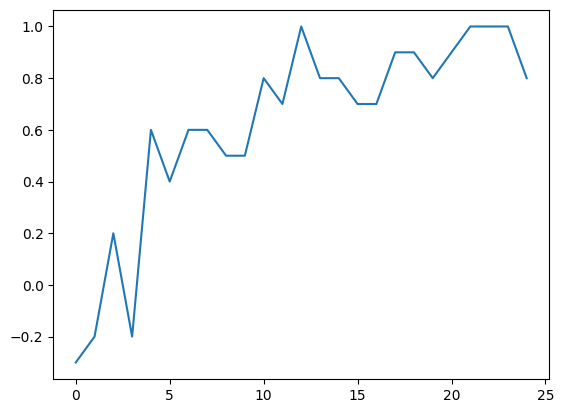

Steps


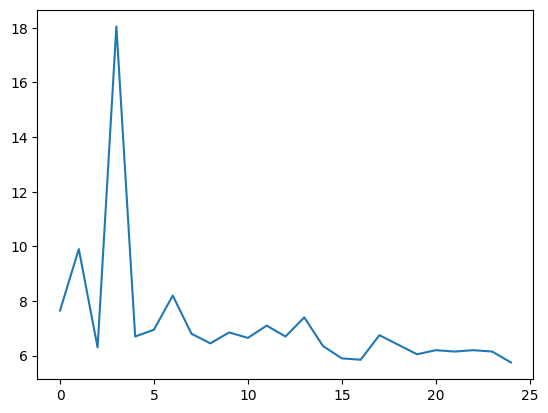

In [12]:
model_dir="models/FrozenLake/"
res=q_network(env_4x4, num_episodes=500,PATH=model_dir)
width = 20

print('Rewards')
res1 = np.asarray(res[0])
result1 = res1[:(res1.size // width) * width].reshape(-1, width).mean(axis=1)
plt.plot(result1)
plt.show()

print('Steps')
res2 = np.asarray(res[1])
result2 = res2[:(res2.size // width) * width].reshape(-1, width).mean(axis=1)
plt.plot(result2)
plt.show()

<br> 

We zien dat het model heel snel leert wat de korste weg is. Natuurlijk gaat het nog niet altijd goed, ook omdat er een greedy beslis regel is zal er al af en toe een verkeerde keuze worden gemaakt. 

<br>

### __Q1.c__ (3 punten)
Laat nu ook zien wat de weights/Q-values zijn voor de vier mogelijke acties in het hokje links naast de frisbee (state 14). Heeft de beste actie ook de hoogste waarde?

In [15]:
# TO DO
print("Weights after training")
print(res)

Weights after training
([-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1

# laat je netwerk spelen

Nu je je netwerk hebt getraind kan je hem natuurlijk ook het frozen lake laten oplossen. Met de volgende code kan je je netwerk de gym laten spelen.

In [ ]:
def displayImage(image):
    plt.imshow(image)
    plt.show()

In [ ]:
env=env_4x4
state_size = env.observation_space.n
action_size = env.action_space.n
model = QNetwork(state_size, action_size)
num_rounds = 10
num_episodes= 2

PATH=model_dir
filename="model"

model.load_state_dict(torch.load(PATH+filename+".pt"))
model.eval()

for i in range(num_episodes):
    state, _ = env.reset()
    rAll = 0
    done = False
    j = 0

    while not done and j < num_rounds:

        j += 1

        state_tensor = torch.FloatTensor(np.identity(state_size)[state]).unsqueeze(0)

        Q_values = model(state_tensor)
        _, predicted_action = torch.max(Q_values, 1)

        action = predicted_action.item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        if done and reward == 0:
            reward = -1

        state = next_state

        displayImage(env.render())

## 2. Working Memory --> Experience Replay

Over de tijd zijn de Q_networks op vele manier uitgebreid om nog beter te kunnen leren. Een ding waar we straks naar gaan kijken is het toevoegen van meerdere lagen. Maar zo is er ook het idee van experience replay, iets wat gebaseerd is op hoe de hersens van mensen en dieren werken  (zie colleges).

Experience is dat het netwerk, tussen leerepisodes door, zich herinnert wat hij hiervoor gedaan heeft en wat de uitkomst daar van was. Deze herinneringen worden dan weer gebruikt om van te leren (alsof elke herinnering een echte gebeurtenis was). Experience replay wordt veel gebruikt in deep reinforcement learning, en helpt daar het netwerk stabiele representaties vormen. 

Wat we hier gaan doen is experience replay toevoegen aan dit simpele Q_netwerk. Het zal dit netwerk niet meteen veel beter maken, omdat het probleem erg makkelijk is en het netwerk simpel, maar kan wel overzichtelijk het principe illustreren. 

Je hebt hier eigenlijk maar een aantal dingen voor nodig; een memory buffer 
 
 `memory = []`

In deze buffer sla voor elke ronde op wat er gebeurde. De staat waar in je was, welke actie je hebt ondernomen, of je een beloning kreeg, welke staat je terecht kwam en of dit het einde van de episode was):   

`memory.append((state, action, reward, next_state, done))`

Dan, aan het eind van elke episode, haal je 30 willekeurige herinneringen boven en speelt deze weer uit alsof het echt gebeurde (dus zorgt voor een zelfde update in weights als normaal leren). Bij het begin van een nieuwe leer episode wordt de buffer weer leeggemaakt om ruimte te maken voor nieuwe evaringen. 
``` python
if replay > 0:
    for _ in range(30):
        state, action, reward, next_state, done = random.choice(memory)
        
        state_tensor = torch.FloatTensor(np.identity(state_size)[state]).unsqueeze(0)
        next_state_tensor = torch.FloatTensor(np.identity(state_size)[next_state]).unsqueeze(0)
        
        Q_values = model(state_tensor)
        next_Q_values = model(next_state_tensor)
        
        target_Q = Q_values.detach().clone()
        target_Q[0][action] = reward + y * torch.max(next_Q_values) * (not done)
        
        loss = criterion(Q_values, target_Q)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
```

zorg ervoor dat je in je functie met behulp van de flag `replay` de optie om met replay memory te werken aan en uit kan zetten.

### __Q2.a__ (4 punten)
Implementeer deze experience replay, door de bovenstaande code op de juiste plekken in `q_network()` te plakken.  Vergelijk de prestatie van het model met en zonder replay.

In [ ]:
# TO DO

> *Antwoord*

In [ ]:
res_replay=q_network(env, num_episodes=500, replay=1)
width = 20

print('Rewards')
res1 = np.asarray(res_replay[0])
result1 = res1[:(res1.size // width) * width].reshape(-1, width).mean(axis=1)
plt.plot(result1)
plt.show()

print('Steps')
res2 = np.asarray(res_replay[1])
result2 = res2[:(res2.size // width) * width].reshape(-1, width).mean(axis=1)
plt.plot(result2)
plt.show()

### __Q2.b__ (4 punten)

We hebben nu naar replay gekeken waarbij je naar willekeurige herinneringen kijkt van de laatste 30 rondes. Het zal waarschijnlijk in deze context niet veel hebben opgeleverd. Ook is dit misschien niet de beste manier van herinneringen ophalen. 


Er zijn verschillende algoritmes bedacht waarbij niet naar willekeurige, maar juist naar specifieke herinneringen werd gekeken om het leren nog verder te optimaliseren. Bedenk een optimalisatie van de replay functie, en beschrijf hoe je dat zou implementeren. Schrijf in je antwoord je motivatie voor je aanpassing (die is belangrijker dan het slagen er van, natuurlijk kan je als je wilt laten zien dat je netwerk beter of slechter werkt maar dat hoeft niet). 

> *Antwoord*